### Some version information

Your versions do not have to be exactly the same, this is just included for reference

In [1]:
import sys
print(f"Python version: {sys.version}")

Python version: 3.10.4 | packaged by conda-forge | (main, Mar 30 2022, 08:38:02) [MSC v.1916 64 bit (AMD64)]


In [7]:
from importlib.metadata import version

for module in ['numpy','matplotlib','scipy']:
    print(module + ': ' + version(module))

numpy: 1.21.5
matplotlib: 3.5.2
scipy: 1.7.3


# 1. The Pendulum

First we look at the motion of a pendulum under gravity when we assume small oscillations and no friction forces. The diagram below (from https://www.acs.psu.edu/drussell/Demos/Pendulum/Pendulum.html) sets the notation for the problem.

<p align="center">
  <img src="pendulum.jpg" width="22%" height="22%"/>
</p>

The equation of motion is $mL\ddot{\theta} = mg\sin\theta$ which can be rearraged to 
\begin{equation}
\ddot{\theta} = \frac{g}{L}\sin\theta
\end{equation}

Under the assumption of small oscillations ($\theta \ll 1$), this reduces to 
$$
\ddot{\theta} = \frac{g}{L}\theta
$$
This equation admits an analytical solution given by

$$\theta(t) = \theta_0 \cos(\omega t)$$

where $\omega = \sqrt{\frac{g}{L}}$. This analytical motion can be easily plotted as follows:

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Following local acceleration due to gravity from 
# https://sciencedemonstrations.fas.harvard.edu/presentations/newtons-apple#:~:text=The%20value%20of%20g%20for,is%209.8038%20m%2Fs2.
# But can we trust Harvard ??
g_cambridge = 9.8038  # In SI units [ms^{-2}]

L = 1.0 # In meters [m]


# Code up the analytical solution
def small_angle_theta(t, omega = np.sqrt(g_cambridge/L), theta0 = np.pi/4):   # we set some reasonable default values
    """ Angular position of a small angle approximation pendulum of frequency omega at time t
        --- Parameters ---
        t   :   time [seconds]
        omega   :   frequency of oscillation [radians per second]
        theta_0 :   angular position of pendulum at time t=0 [raidans]

        --- Returns ---
        theta   :   angular position of pendulum at time t [raidans]
    """ 
    return theta0 * np.cos(omega*t)

Text(0.5, 1.0, 'Motion of small angle pendulum')

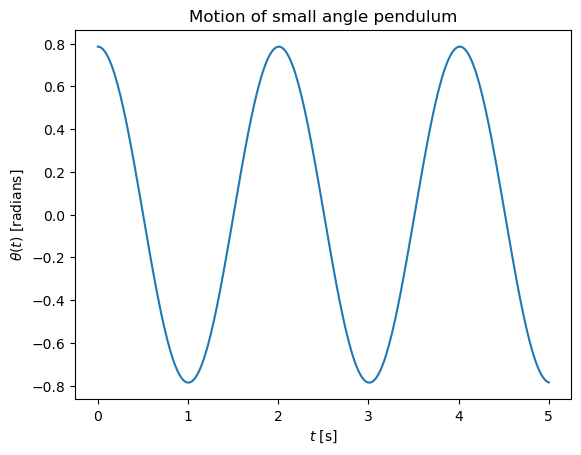

In [18]:
# Make a plot
t_values = np.linspace(0, 5, 300)
small_angle_theta_values = small_angle_theta(t_values) # numpy operations automatically broadcast calculation over whole array of t values

plt.plot(t_values, small_angle_theta_values)
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$\theta (t)$ [radians]")
plt.title("Motion of small angle pendulum")

# 2. Without small angle approximation
If we dont make the small angle approximation, we must solve the nonlinear equation of motion (equation 1) numerically. This involves some approximate scheme where one takes the current position $\theta(t)$ and updates it to a value later in time by some small timestep $\theta(t + dt)$ using the nonlinear equation of motion.